# Applying prophet to time series forecasting of Well and Riser flow rates (Robustness testing)

## Author: Ridha Alkhabaz


## Imports:



In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import math
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from datetime import timedelta
from prophet import Prophet
from pandas import read_csv
from pandas import datetime
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dttm

## Data configuration and readdings:


##### First the riser data needs some special reconfigurations:

In [11]:
# Convert the sequence of seconds into datetime array
def parser(x):
    now_seconds = 0
    y = x.astype(np.float) + now_seconds
    z = pd.to_datetime(y, unit='s')
    return z
# the following are functions to observe the robustness of our model 
def spikes_addition(data, num_points=100, is_well=False):
    # some outliers and spikes
    for i in random.sample(range(0, len(data)), num_points):
        data[i][1] = np.random.uniform(data[:,1].min(),data[:,1].max())
        data[i][2] = np.random.uniform(data[:,2].min(),data[:,2].max())
        data[i][3] = np.random.uniform(data[:,3].min(),data[:,3].max())
        data[i][4] = np.random.uniform(data[:,4].min(),data[:,4].max())
        data[i][5] = np.random.uniform(data[:,5].min(),data[:,5].max())
        if is_well:
            continue
        data[i][6] = np.random.uniform(data[:,6].min(),data[:,6].max())
        data[i][7] = np.random.uniform(data[:,7].min(),data[:,7].max())
        data[i][8] = np.random.uniform(data[:,8].min(),data[:,8].max())
        data[i][9] = np.random.uniform(data[:,9].min(),data[:,9].max())
    return data
def gaussian_noise_addition(data, mu=0, sigma=0.005):
    ## adding noise after normalization 
    noise = np.random.normal(mu, sigma, data[:, 1:].shape)
    data[:, 1:] = data[:, 1:] + noise
    return data
def random_missing_data(data, num_points=100, is_well=False):
    from random import randint
    index = [randint(0, len(data)) for i in range(num_points)]
    if is_well:
        data[index, 1:6] = 0
    else:
        data[index, 1:10] = 0
    return data, index

In [12]:
# Read the data from fname and eventually plot them
def read_data(fname, params=np.array([100, 0, 5e-3, 100])):
    # Read the time series
    datats = read_csv(fname, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Resample the data using a uniform timestep
    datats = datats.resample('S').mean()
    datats = datats.interpolate(method='linear')
    # Convert data to numpy array
    data = datats.reset_index().values
    # Adding spikes:
    data = spikes_addition(data, num_points=int(params[0]))
    # Replace timestamps with seconds
    time_sec = array([data[i, 0].timestamp() for i in range(len(data))])
    data = np.c_[time_sec, data[:, 1:]]

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    scaler.scale_[0] = 1    # Do not normalize time

    # Apply the same normalization to all pressure readings
    pind = list(range(1, 8))  # Indices of pressure readings
    pmin = scaler.data_min_[pind].min()
    pmax = scaler.data_max_[pind].max()
    scaler.scale_[pind] = ((scaler.feature_range[1] - scaler.feature_range[0]) / (pmax - pmin))
    scaler.min_[pind] = scaler.feature_range[0] - pmin * scaler.scale_[pind]

    data = scaler.transform(data)
    # Adding gaussian noise
    data = gaussian_noise_addition(data, mu=params[1], sigma=params[2])
    
    # Removing some points:
    data, _ = random_missing_data(data, num_points=int(params[3]))

    return data, scaler

## Deploying Prophet:
### The riser data set:

In [7]:
data, _= read_data('riser_pq_uni.csv', params=np.array([100, 0, 5e-3, 100]))
dft = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], data.T)))
trainSet = dft.iloc[:int(0.7*len(dft))]
testSet = dft.iloc[int(0.7*len(dft)):len(dft)]

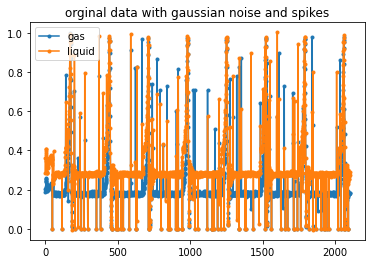

In [8]:
start_ploting = 0
end_ploting = len(trainSet)
fig,ax = plt.subplots()
ax.set_title('orginal data with gaussian noise and spikes')
ax.plot(trainSet['ds'].iloc[start_ploting:end_ploting], trainSet['gas(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='gas')
ax.plot(trainSet['ds'].iloc[start_ploting:end_ploting], trainSet['liquid(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='liquid')
ax.legend()

In [14]:
def model_riser_fit(train, test, y='gas(m3/day)'):
    train = train.rename(columns={y:'y'})
    test = test.rename(columns={y:'y'})
    if y == 'gas(m3/day)':
        prop = Prophet(daily_seasonality=True,changepoint_prior_scale=0.01, seasonality_prior_scale=10.0)
        prop.add_regressor('p1')
        prop.add_regressor('p2')
        prop.add_regressor('p3')
        prop.add_regressor('p4')
        prop.add_regressor('p5')
        prop.add_regressor('p6')
        prop.add_regressor('p7')
        prop.fit(train)
        forecast = prop.predict(test.drop(columns="y"))
        return prop, forecast
    # liquid prediction
    m = Prophet(daily_seasonality=True,changepoint_prior_scale=0.01, seasonality_prior_scale=10.0)
    m.add_regressor('p1')
    m.add_regressor('p2')
    m.add_regressor('p3')
    m.add_regressor('p4')
    m.add_regressor('p5')
    m.add_regressor('p6')
    m.add_regressor('p7')
    m.fit(train)
    forecast = m.predict(test.drop(columns="y"))
    return m, forecast

In [15]:
# Gas 
gas_model, pred_gas = model_riser_fit(trainSet, testSet, y='gas(m3/day)')
pred_gas['ds'] = range(2100, 3001)
# liquid
liq_model, pred_liq = model_riser_fit(trainSet, testSet, y='liquid(m3/day)')
pred_liq['ds'] = range(2100, 3001)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


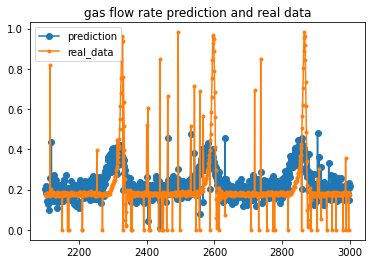

In [16]:
start_ploting = 0
end_ploting = len(testSet)
fig,ax = plt.subplots()
ax.set_title('gas flow rate prediction and real data')
ax.plot(pred_gas['ds'].iloc[start_ploting:end_ploting], pred_gas['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(testSet['ds'].iloc[start_ploting:end_ploting], testSet['gas(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')

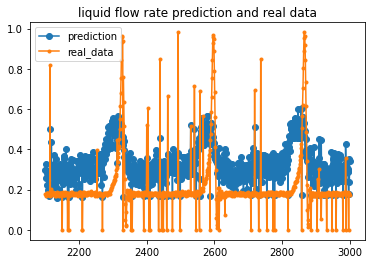

In [17]:
start_ploting = 0
end_ploting = len(testSet)
fig,ax = plt.subplots()
ax.set_title('liquid flow rate prediction and real data')
ax.plot(pred_liq['ds'].iloc[start_ploting:end_ploting], pred_liq['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(testSet['ds'].iloc[start_ploting:end_ploting], testSet['gas(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')

In [18]:
def mse(real, pred):
    return mean_squared_error(real, pred)
[mse(testSet['gas(m3/day)'], pred_gas['yhat']), mse(testSet['liquid(m3/day)'], pred_liq['yhat'])]

[0.017785318597675612, 0.016508246653805358]

#### Finding the best parameters:

In [ ]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

trainSet = trainSet.rename(columns={'gas(m3/day)':'y'})
from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).add_regressor('p1').add_regressor('p2').add_regressor('p3').add_regressor('p4')\
                         .add_regressor('p5').add_regressor('p6').add_regressor('p7').fit(trainSet)  # Fit model with given params
    df_cv = cross_validation(m,horizon='1 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

#### Well dataset:

In [1]:
def read_data(fname, params=[100, 0, 5e-3, 10]):
    # Read the time series
    datats = read_csv(fname, header=0, dayfirst=True, parse_dates=[0], index_col=0, squeeze=True)  # , date_parser=parser

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Convert data to numpy array
    data = datats.reset_index().values

    # Split data into flow periods, and resample each flow period using a uniform timestep
    dt = np.ediff1d(data[:, 0])
    fpbreak = dttm.timedelta(hours=1)  # Minimal break between flow periods
    dt = dt - fpbreak
    ind = np.where(dt - fpbreak > pd.Timedelta(0))[0]
    ind = np.r_[ind, len(data)-1]

    Nfp = len(ind)  # Number of flow periods
    fp = ['None'] * Nfp
    n0 = 0
    n1 = ind[0]+1
    for n in range(Nfp):
        # Resample each flow period separately
        fpts = datats[n0:n1].resample('T').mean()
        fpts = fpts.interpolate(method='linear')
        # Save the resampled flow period to a list of numpy arrays
        fp[n] = fpts.reset_index().values
        #fp[n] = data[n0:n1,:]
        n0 = n1
        if n+1 < Nfp:
            n1 = ind[n+1] + 1   
    
        
    # Get the normalization parameters for all data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[:,1:]) # Exclude Datetime from normalization

    # Normalize every flow period
    for n in range(Nfp):
        
        fp[n][:,1:] = scaler.transform(fp[n][:,1:])
    #adding some gaussian noise 
        fp[n][:,:] = gaussian_noise_addition(fp[n][:,:], mu=params[1], sigma=params[2])
    
    # Removing some points:
        fp[n][:,:], _ = random_missing_data(fp[n][:,:], num_points=int(params[3]), is_well=True)

    return fp, headers, scaler

#### Reading the data:

In [2]:
fp,headers, _ = read_data('welltest.csv')

NameError: name 'read_csv' is not defined

In [115]:
df_epochs = np.array(range(3))
df = pd.DataFrame.from_dict(dict(zip(headers, fp[df_epochs[0]].T)))
for i in df_epochs[1:]:
    tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
    df = pd.concat([df,tmp], axis=0)
df = df.rename(columns={'DateTime':'ds'})
train = df
test = pd.DataFrame.from_dict(dict(zip(headers, fp[3].T)))
test = test.rename(columns={'DateTime':'ds'})

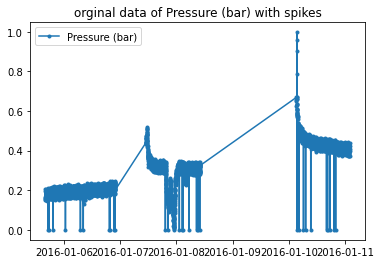

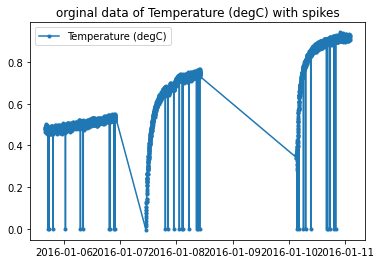

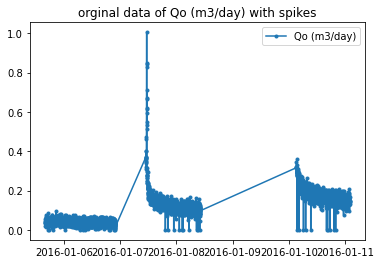

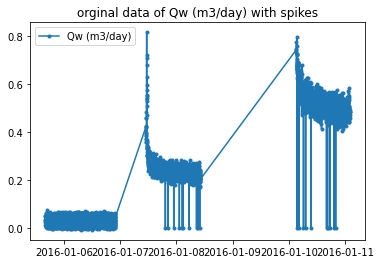

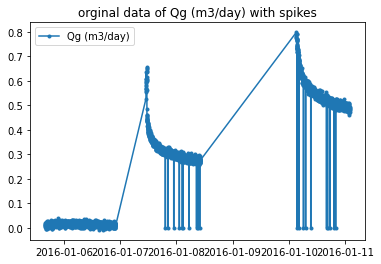

In [116]:
start  = 0
end = len(df)
for i in headers[1:]:
    fig,ax = plt.subplots()
    ax.set_title('orginal data of %s with spikes'%i)
    ax.plot(df['ds'].iloc[start:end], df[i].iloc[start:end], marker=".", label='%s'%i)
    ax.legend()

#### Fitting:

In [117]:
def model_well_fit(train, test, y='Qo (m3/day)'):
    trainSet = train.rename(columns={y:'y'})
    testSet = test.rename(columns={y:'y'})
    if y == 'Qo (m3/day)':
        model_oil = Prophet( daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, \
                 holidays_prior_scale=10.0, seasonality_mode='multiplicative')
        model_oil.add_regressor('Pressure (bar)')
        model_oil.add_regressor('Temperature (degC)')
        model_oil.fit(trainSet)
        oil_test = model_oil.predict(testSet.drop(columns="y"))
        oil_train = model_oil.predict(trainSet.drop(columns="y"))
        return model_oil, oil_test, oil_train
    if y == 'Qw (m3/day)':
        model_water = Prophet( daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, \
                 holidays_prior_scale=10.0, seasonality_mode='multiplicative')
        model_water.add_regressor('Pressure (bar)')
        model_water.add_regressor('Temperature (degC)')
        model_water.fit(trainSet)
        water_test = model_water.predict(testSet.drop(columns="y"))
        water_train = model_water.predict(trainSet.drop(columns="y"))
        return model_water,water_test, water_train
    
    model_gas = Prophet( daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, \
                 holidays_prior_scale=10.0, seasonality_mode='multiplicative')
    model_gas.add_regressor('Pressure (bar)')
    model_gas.add_regressor('Temperature (degC)')
    model_gas.fit(trainSet)
    gas_test = model_gas.predict(testSet.drop(columns="y"))
    gas_train = model_gas.predict(trainSet.drop(columns="y"))
    return model_gas, gas_test, gas_train

In [118]:
## gas 
gas_model, gas_ts, gas_tr = model_well_fit(train, test, y='Qg (m3/day)')
## oil 
oil_model, oil_ts, oil_tr = model_well_fit(train, test, y='Qo (m3/day)')
## water 
water_model, water_ts, water_tr = model_well_fit(train, test, y='Qw (m3/day)')

In [99]:
[mse(gas_ts['yhat'], test['Qg (m3/day)']),\
 mse(oil_ts['yhat'], test['Qo (m3/day)']),\
 mse(water_ts['yhat'], test['Qw (m3/day)']) ]

[0.003430229679247305, 0.0007389582596536328, 0.005875441721159363]

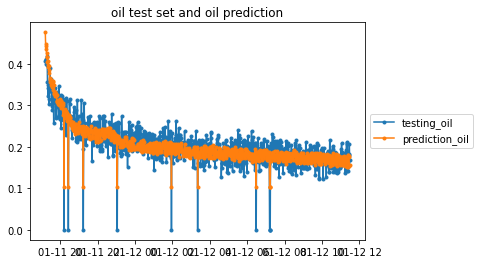

In [100]:
starting = 0
ending = len(testSet)
fig,ax = plt.subplots()
ax.set_title('oil test set and oil prediction')
ax.plot(testSet['ds'].iloc[starting:ending], testSet['Qo (m3/day)'].iloc[starting:ending], marker=".", label='testing_oil')
ax.plot(oil_ts['ds'].iloc[starting:ending], oil_ts['yhat'].iloc[starting:ending], marker=".", label='prediction_oil')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

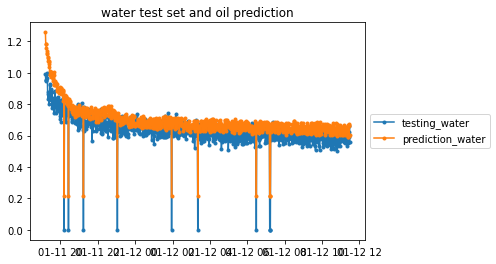

In [101]:
starting = 0
ending = len(testSet)
fig,ax = plt.subplots()
ax.set_title('water test set and oil prediction')
ax.plot(testSet['ds'].iloc[starting:ending], testSet['Qw (m3/day)'].iloc[starting:ending], marker=".", label='testing_water')
ax.plot(water_ts['ds'].iloc[starting:ending], water_ts['yhat'].iloc[starting:ending], marker=".", label='prediction_water')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

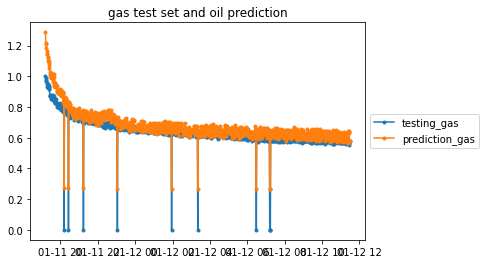

In [102]:
starting = 0
ending = len(testSet)
fig,ax = plt.subplots()
ax.set_title('gas test set and gas prediction')
ax.plot(testSet['ds'].iloc[starting:ending], testSet['Qg (m3/day)'].iloc[starting:ending], marker=".", label='testing_gas')
ax.plot(gas_ts['ds'].iloc[starting:ending], gas_ts['yhat'].iloc[starting:ending], marker=".", label='prediction_gas')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Finding the best parameters


In [103]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive'],
    'daily_seasonality': [True, False], 
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

In [121]:
from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
gas_rmse = []
water_rmse = []
oil_rmse = []
# run this for three different 
for params in all_params:
    for i in range(0,3):
        trainSet_param = train
        if i == 0:
            trainSet_param = trainSet_param.rename(columns={'Qo (m3/day)':'y'})
            m_oil = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (degC)').fit(trainSet_param)  
            df_cv_oil = cross_validation(m_oil,horizon='1 days', initial='3 days', parallel="processes")
            df_p_oil = performance_metrics(df_cv_oil, rolling_window=1)
            oil_rmse.append(df_p_oil['rmse'].values[0])
        if i == 1:
            trainSet_param = trainSet_param.rename(columns={'Qg (m3/day)':'y'})
            m_gas = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (degC)').fit(trainSet_param)  
            df_cv_gas = cross_validation(m_gas,horizon='1 days', initial='3 days', parallel="processes")
            df_p_gas = performance_metrics(df_cv_gas, rolling_window=1)
            gas_rmse.append(df_p_gas['rmse'].values[0])
        if i == 2:
            trainSet_param = trainSet_param.rename(columns={'Qw (m3/day)':'y'})
            m_water = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (degC)').fit(trainSet_param)  
            df_cv_water = cross_validation(m_water,horizon='1 days', initial='3 days', parallel="processes")
            df_p_water = performance_metrics(df_cv_water, rolling_window=1)
            water_rmse.append(df_p_water['rmse'].values[0])

INFO:prophet:Making 2 forecasts with cutoffs between 2016-01-09 13:57:00 and 2016-01-10 01:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdc72af3410>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 2 forecasts with cutoffs between 2016-01-09 13:57:00 and 2016-01-10 01:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdc7a3f3150>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 2 forecasts with cutoffs between 2016-01-09 13:57:00 and 2016-01-10 01:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdc7c5287d0>
Process ForkProcess-17:
Process ForkProcess-20:
Process ForkProcess-19:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, i

KeyboardInterrupt: 

  File "/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
